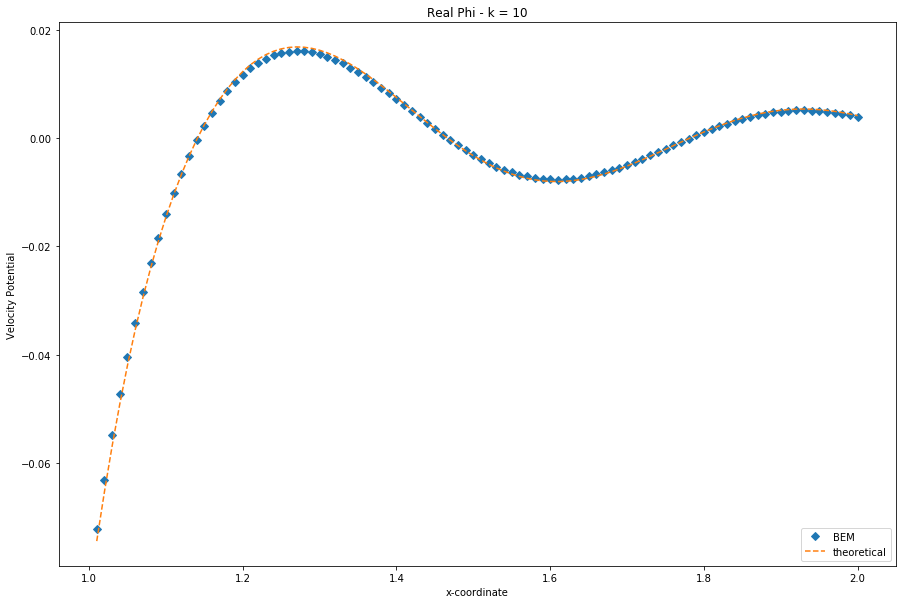

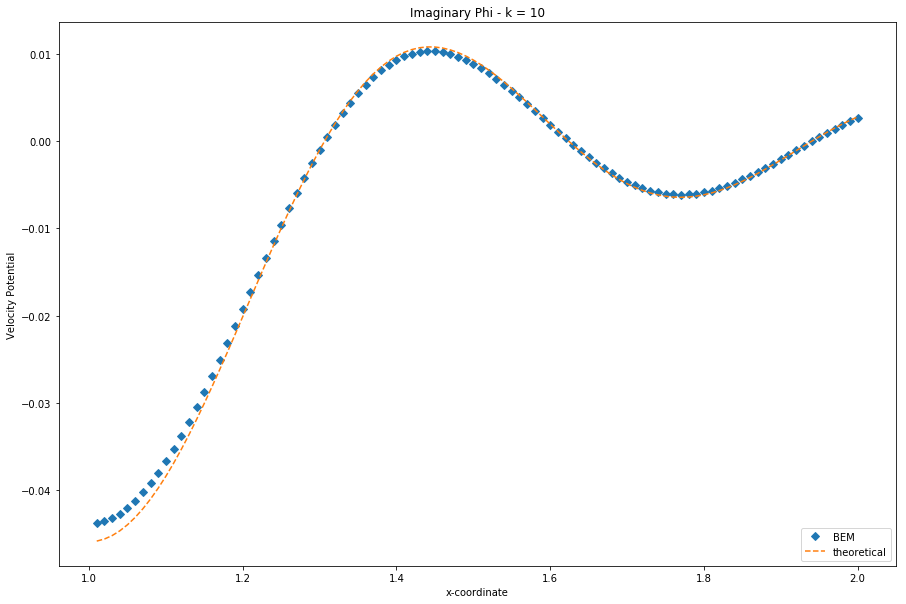

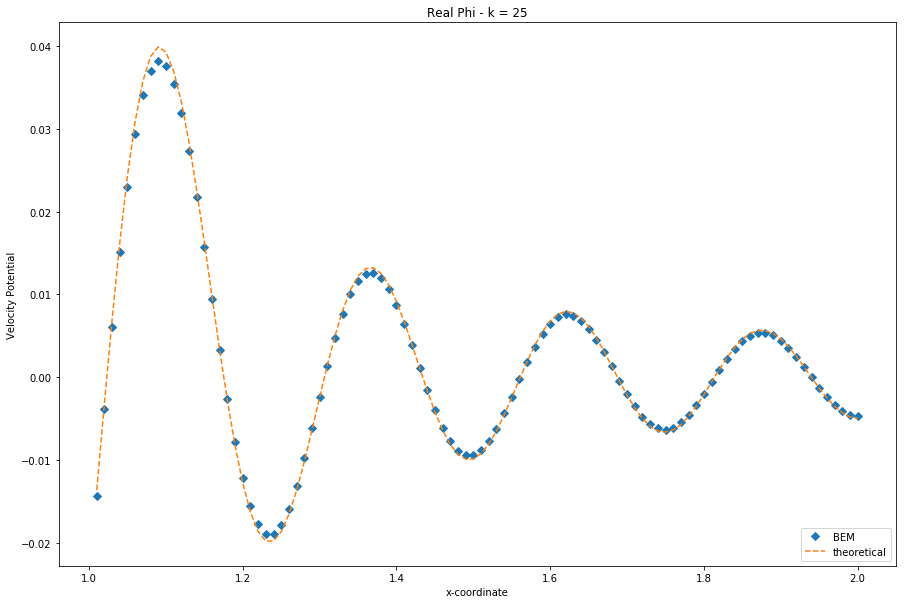

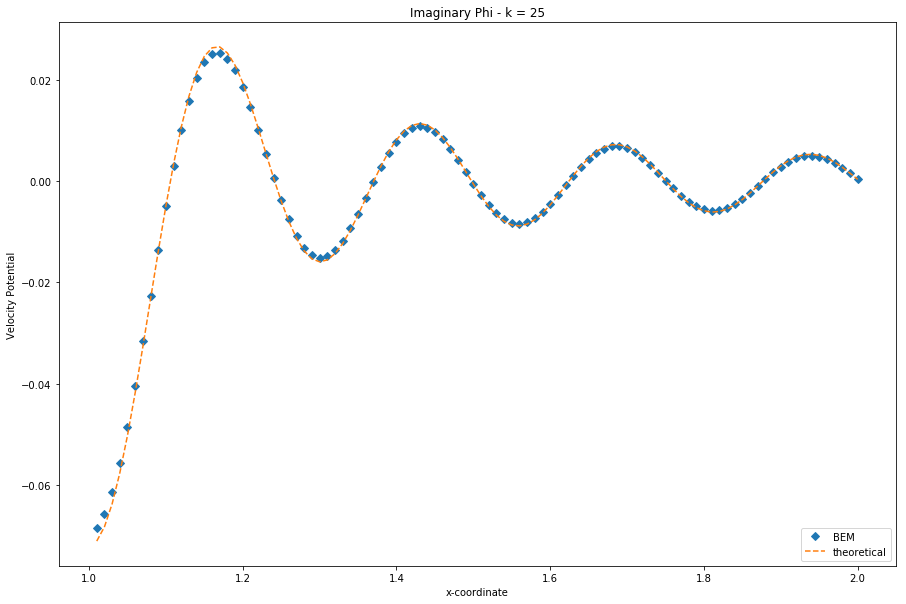

In [4]:
import numpy as np
from ExampleBoundaries import Disk3D
from AcousticProperties import *
from RayleighSolver import *

import matplotlib.pyplot as plt
%matplotlib inline

def plotVelocityPotential(title, x, y1, y2):
    plt.rcParams['figure.figsize'] = [15, 10]
    plt.title(title)
    bem, = plt.plot(x, y1, 'D', label='BEM')
    close, = plt.plot(x, y2, '--', label='theoretical')
    plt.xlabel('x-coordinate')
    plt.ylabel('Velocity Potential')
    plt.legend(handles=[bem, close], loc='lower right')
    plt.show()

def phiAnalytic(k, density, c, V, r, x):
    y = np.subtract(x, 1.0)
    const = -1j * V / k
    variable = np.exp(np.multiply(1j * k, y)) - np.exp(1j * k * np.sqrt(np.square(r) + np.square(y)))
    return const * variable

exteriorPoints = np.zeros((100, 3), dtype=np.float32)
exteriorPoints[:,0] = np.linspace(1.01, 2.0, num=100)

# Test Problem 1

k = 10.0 # Wavenumber
frequency = wavenumberToFrequency(k)

solver = RayleighSolver3D(*(Disk3D()))

boundaryCondition = BoundaryCondition(solver.aElement.shape[0])
boundaryCondition.alpha.fill(0.0)
boundaryCondition.beta.fill(1.0)
boundaryCondition.f.fill(1.0)

solution = solver.solveBoundary(k, boundaryCondition)
samples = solver.solveSamples(solution, exteriorPoints)

x = [p[0] for p in exteriorPoints]
p = phiAnalytic(k, solver.density, solver.c, 1, 0.1, x)

plotVelocityPotential('Real Phi - k = 10', x, samples.real, p.real)
plotVelocityPotential('Imaginary Phi - k = 10', x, samples.imag, p.imag)


# Test Problem 2

k = 25.0 # Wavenumber
frequency = wavenumberToFrequency(k)

solver = RayleighSolver3D(*(Disk3D()))

boundaryCondition = BoundaryCondition(solver.aElement.shape[0])
boundaryCondition.alpha.fill(0.0)
boundaryCondition.beta.fill(1.0)
boundaryCondition.f.fill(1.0)

solution = solver.solveBoundary(k, boundaryCondition)
samples = solver.solveSamples(solution, exteriorPoints)

x = [p[0] for p in exteriorPoints]
p = phiAnalytic(k, solver.density, solver.c, 1, 0.1, x)

plotVelocityPotential('Real Phi - k = 25', x, samples.real, p.real)
plotVelocityPotential('Imaginary Phi - k = 25', x, samples.imag, p.imag)

